In [2]:
curr_dir = '/user_data/vayzenbe/GitHub_Repos/ginn'
import sys
sys.path.insert(1, f'{curr_dir}')
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from plotnine import *

import pdb
import os
import warnings
import ginn_params as params
from glob import glob as glob

warnings.filterwarnings("ignore")

In [3]:
results_dir = f'{curr_dir}/results'
#training info

exp = 'aeronaut'

study_dir,subj_dir, sub_list, vid, file_suf, fmri_tr, data_dir, vols, tr, fps, bin_size, ages = params.load_params(exp)
'''
Model predictors
'''
model_arch = 'cornet_z_sl'
model_types = ['random','imagenet_noface', 'imagenet_oneface', 'imagenet_vggface', 'vggface_oneobject', 'vggface']
layer = 'aIT'

'''
Human predictors
'''

bi_rois = ['EVC','FFA','A1'] 
lat_rois = ['lEVC','rEVC','lFFA','rFFA','lA1','rA1']
rois = bi_rois + lat_rois
rois = bi_rois


predictor_rois = rois

#ages = [5, 6, 7, 18]
#convert ages to sring
ages = [str(age) for age in ages]



In [4]:
def create_bar(data, x_val, y_val,fill_val, err=0, title_val='None'):

    plot = ggplot(data, aes(x = x_val, y = y_val, fill = fill_val)) + \
        geom_col(stat='identity',color = 'black', position='dodge') + \
        geom_linerange(aes(x=x_val,  ymax = f'{y_val} + {err}', ymin = f'{y_val} - {err}'), size = 1, position=position_dodge(width=.9)) + \
        theme_classic() + \
        xlab('ROI') + ylab('Correlation') + \
        geom_text(aes(y= f'{y_val} - ({y_val})/2', label = 'layer'), angle = 90, color = 'white', size = 12, position=position_dodge(width=.9)) + \
        theme(text = element_text(color ='black'), 
            axis_text_x= element_text(angle = 30, size = 12),
            axis_text_y= element_text(size = 12),
            axis_title=element_text(size = 14),
            axis_line=element_line(), 
            panel_border=element_blank(),
            figure_size = (10, 5))+ \
            ggtitle(title_val)

    print(plot)

### Predict Mean Timecourse across subs

Fit to mean TS for 50% of subs, predict left-out 50%

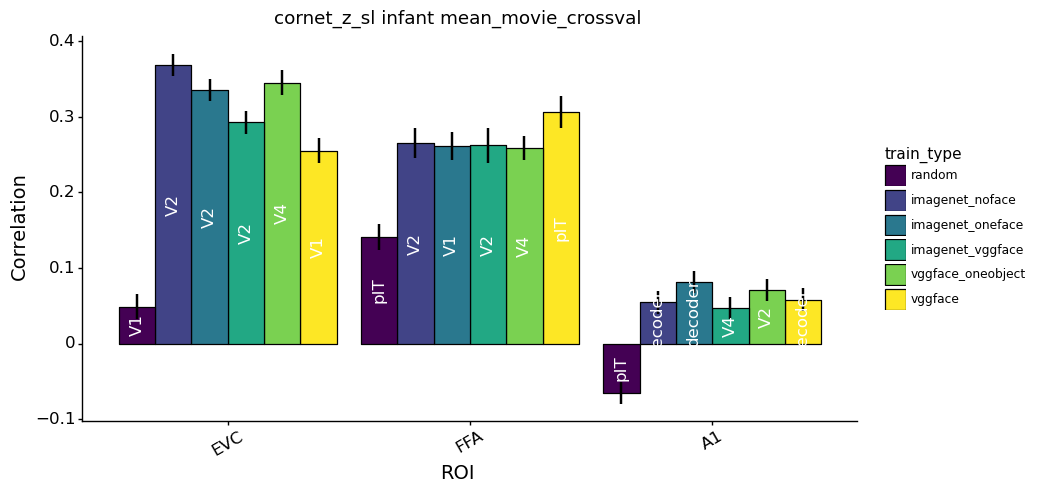

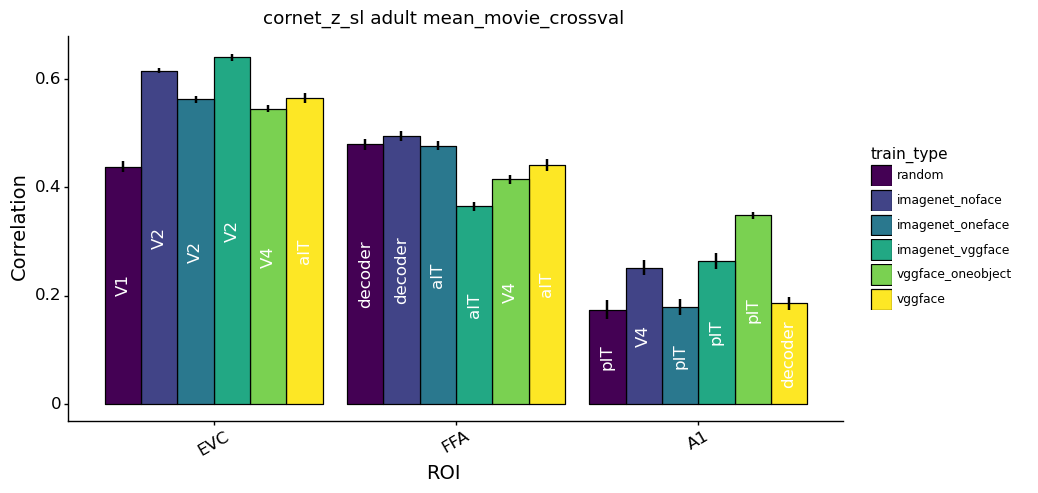

In [6]:
"""
Plot model data from best layer
"""

file_suf = ''
predictor = 'cornet_z_sl'
analysis_type = 'mean_movie_crossval'


roi_sets = [bi_rois] + [lat_rois]
roi_sets = [bi_rois]

#rois = ['FFA']
#roi = [rois]


summary_df = pd.read_csv(f'{results_dir}/mean_ts/{exp}_{predictor}_{analysis_type}{file_suf}.csv')
#convert age to string
summary_df['age'] = summary_df['age'].astype(str)
summary_df['train_type'] = pd.Categorical(summary_df['train_type'], categories = model_types, ordered = True)

#remove decoder layer
#summary_df = summary_df[summary_df['layer'] != 'decoder']

#extract best layer for each model and each roi
best_layer_df = pd.DataFrame(columns = summary_df.columns)
for rois in roi_sets:
    for trt in model_types:
        for roi in rois:
            for age in ages:

                curr_df = summary_df[(summary_df['train_type'] == trt) & (summary_df['roi'] == roi) & (summary_df['age'] == age)]
                #sort by correlation
                curr_df = curr_df.sort_values(by = 'corr', ascending = False)
                #add top row to best_layer_df
                best_layer_df = best_layer_df.append(curr_df.iloc[0,:], ignore_index=True)

for roi in roi_sets:

    #extract rois from summary file
    roi_data = best_layer_df[best_layer_df['roi'].isin(roi)]
    
    roi_data['roi'] = pd.Categorical(roi_data['roi'], categories = roi, ordered = True)
    roi_data['train_type'] = pd.Categorical(roi_data['train_type'], categories = model_types, ordered = True)
    for age in ages:

        #plot corr data as bar graph
        corr_data = roi_data[roi_data['age'] == age]
        #convert corr to values
        corr_data['corr'] = corr_data['corr'].astype(float)
        #convert se to values
        corr_data['se'] = corr_data['se'].astype(float)
        #covert ci to values

        #convert noise ceiling to values
        #corr_data['noise_ceiling'] = corr_data['noise_ceiling'].astype(float)

        create_bar(corr_data, 'roi', 'corr','train_type', 'se',  f'{predictor} {age} {analysis_type}')


In [65]:
file_names

['/user_data/vayzenbe/GitHub_Repos/ginn/results/top_ims/cornet_z_sl_imagenet_noface_V4_FFA_face_infant_images.csv',
 '/user_data/vayzenbe/GitHub_Repos/ginn/results/top_ims/cornet_z_sl_imagenet_oneface_pIT_FFA_face_infant_images.csv',
 '/user_data/vayzenbe/GitHub_Repos/ginn/results/top_ims/cornet_z_sl_vggface_oneobject_decoder_FFA_face_infant_images.csv',
 '/user_data/vayzenbe/GitHub_Repos/ginn/results/top_ims/cornet_z_sl_imagenet_vggface_V4_FFA_face_infant_images.csv']

In [59]:
file_names = glob(f'{results_dir}/top_ims/{model_arch}_*_{roi}_face_infant*.csv') + glob(f'{results_dir}/top_ims/{model_arch}_*_{roi}_face_adult*.csv')

nn =0 
#loop through file names and load 
for file_name in file_names:
    
    curr_df = pd.read_csv(file_name)
    #if file name contains infant, add infant column
    if 'infant' in file_name:
        curr_df['age'] = 'infant'
    else:
        curr_df['age'] = 'adult'

    if nn == 0:
        summary_df = curr_df
    else:
        #append to summary
        summary_df = summary_df.append(curr_df, ignore_index=True)
    nn += 1

#remove duplicate rows
summary_df = summary_df.drop_duplicates()

In [63]:
summary_df['age']

0     infant
1     infant
2     infant
3     infant
4     infant
5     infant
6     infant
7     infant
8     infant
9     infant
10    infant
11    infant
12    infant
13    infant
14    infant
15    infant
16    infant
17    infant
18    infant
19    infant
20    infant
21    infant
22    infant
23    infant
24    infant
25    infant
26    infant
27    infant
28    infant
29    infant
30    infant
31    infant
32    infant
33    infant
34    infant
35    infant
36    infant
37    infant
38    infant
39    infant
Name: age, dtype: object

In [61]:
curr_df = summary_df[(summary_df['train_type'] == trt) & (summary_df['age'] == age)]

KeyError: 0

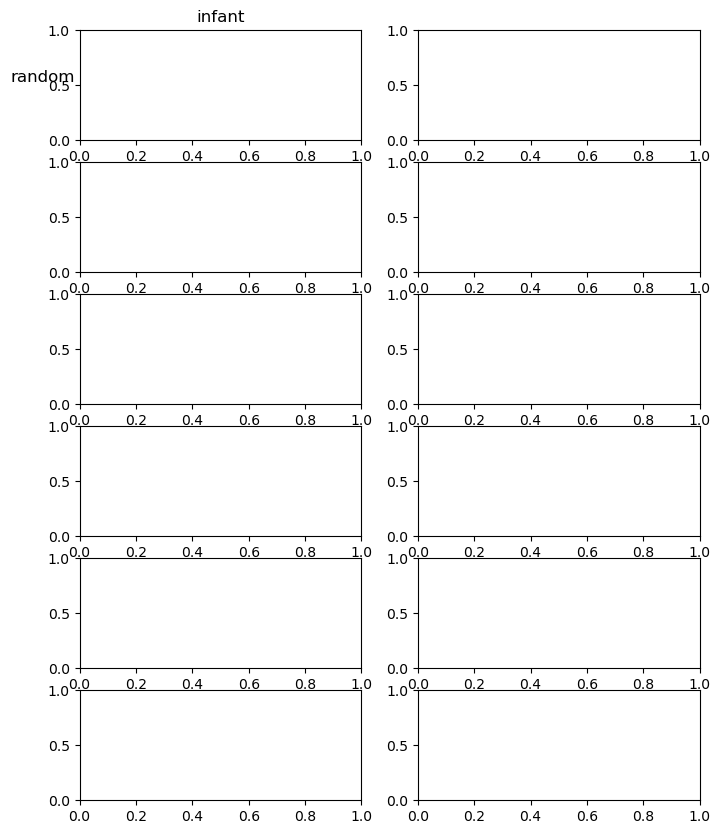

In [60]:
'''Arrange images in a grid'''

#loop through models and load data
roi = 'FFA'
#glob csv file with model name

#create a grid of image plots
fig, ax = plt.subplots(len(model_types), len(ages), figsize = (8,10))

#plot image in n row and m column of grid
for n, trt in enumerate(model_types):
    
    #add label for row
    ax[n,0].set_ylabel(trt, rotation=0, size='large')
    for m, age in enumerate(ages):

        #add label for column
        ax[0,m].set_title(age)
        #extract data for current model and age
        curr_df = summary_df[(summary_df['train_type'] == trt) & (summary_df['age'] == age)]
        #sort by correlation
        curr_df = curr_df.sort_values(by = 'pred', ascending = False).reset_index(drop=True)
        #get top image
        print(curr_df['image'][0])
        #load image
        im = plt.imread(curr_df['image'][0])
        
        #plot image
        ax[n,m].imshow(im)

        #remove axis
        ax[n,m].axis('off')

fig.tight_layout()
 



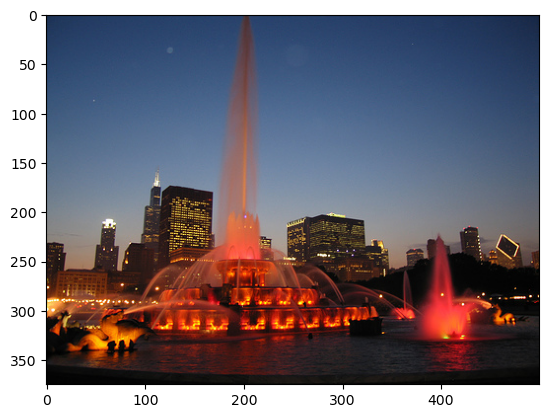

In [52]:
plt.imshow(im)


In [14]:
file_name

['/user_data/vayzenbe/GitHub_Repos/ginn/results/top_ims/cornet_z_sl_vggface_decoder_FFA_infant_images.csv',
 '/user_data/vayzenbe/GitHub_Repos/ginn/results/top_ims/cornet_z_sl_vggface_oneobject_pIT_FFA_infant_images.csv']

In [5]:
'''
Model summary file
'''
file_suf = ''
predictor = 'model'
analysis_type = 'mean_movie_crossval'
dv_ages = ages

roi_sets = [bi_rois] + [lat_rois]
roi_sets = [bi_rois]

summary_df = pd.read_csv(f'{results_dir}/mean_ts/{exp}_{predictor}_{analysis_type}{file_suf}.csv')
#extract layer aIT
summary_df = summary_df[summary_df['layer'] == 'aIT']

#remove A1 rois from summary file
#summary_df = summary_df[summary_df['roi'] != 'lA1']
#summary_df = summary_df[summary_df['roi'] != 'rA1']
#summary_df = summary_df[summary_df['roi'] != 'A1']

summary_df['train_type'] = pd.Categorical(summary_df['train_type'], categories = model_types, ordered = True)
#convert age column to string
summary_df['age'] = summary_df['age'].astype(str)


for roi in roi_sets:
    #extract rois from summary file
    roi_data = summary_df[summary_df['roi'].isin(roi)]
    
    roi_data['roi'] = pd.Categorical(roi_data['roi'], categories = roi, ordered = True)
    for age in dv_ages:

        #plot corr data as bar graph
        corr_data = roi_data[roi_data['age'] == age]
         #convert corr to values
        corr_data['corr'] = corr_data['corr'].astype(float)
        #convert se to values
        corr_data['se'] = corr_data['se'].astype(float)
        #convert noise ceiling to values
        #corr_data['noise_ceiling'] = corr_data['noise_ceiling'].astype(float)
        create_bar(corr_data, 'roi', 'corr','train_type', 'se',  f'{predictor} {age} {analysis_type}')


### ISCs

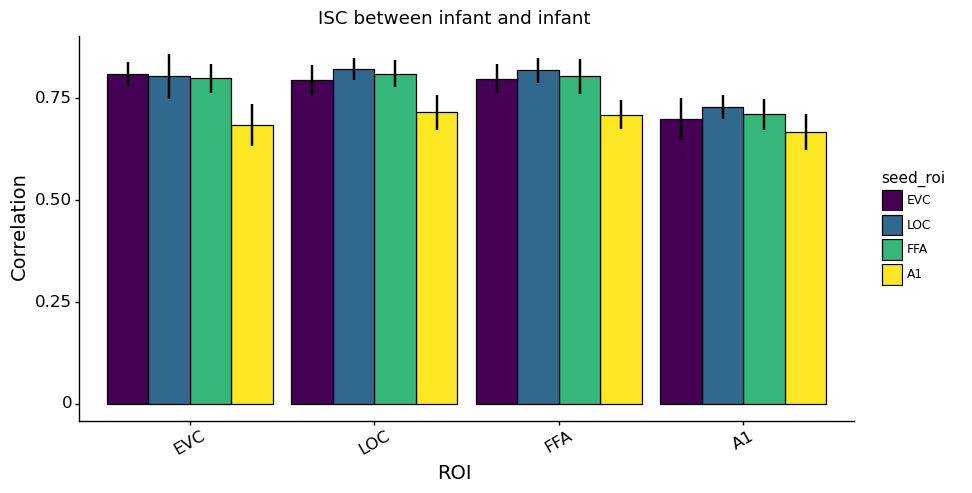

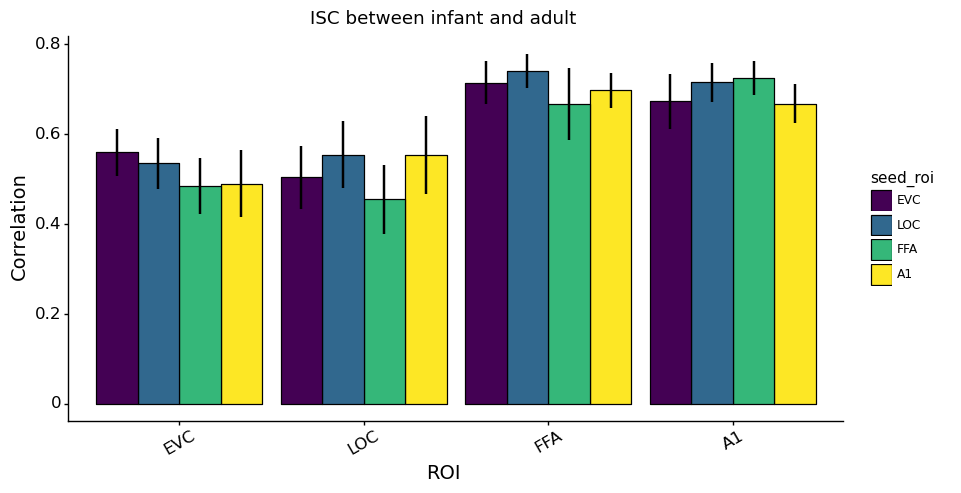

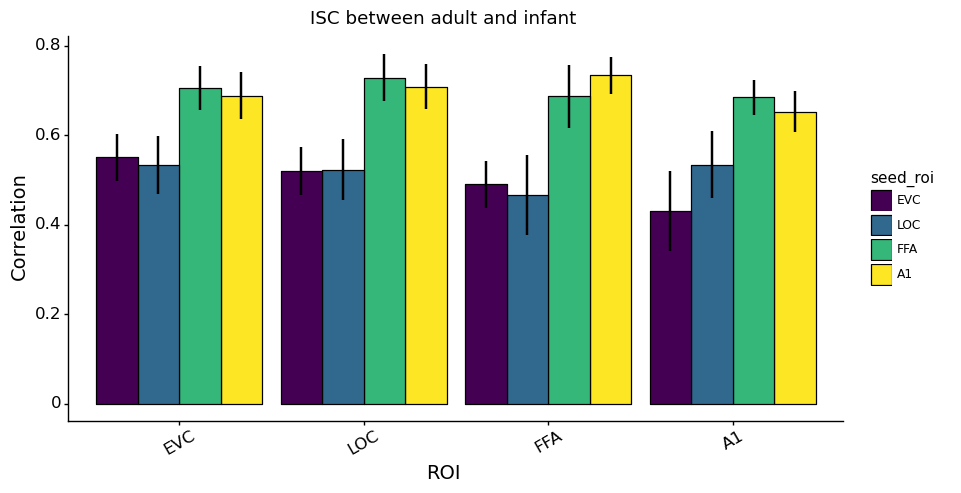

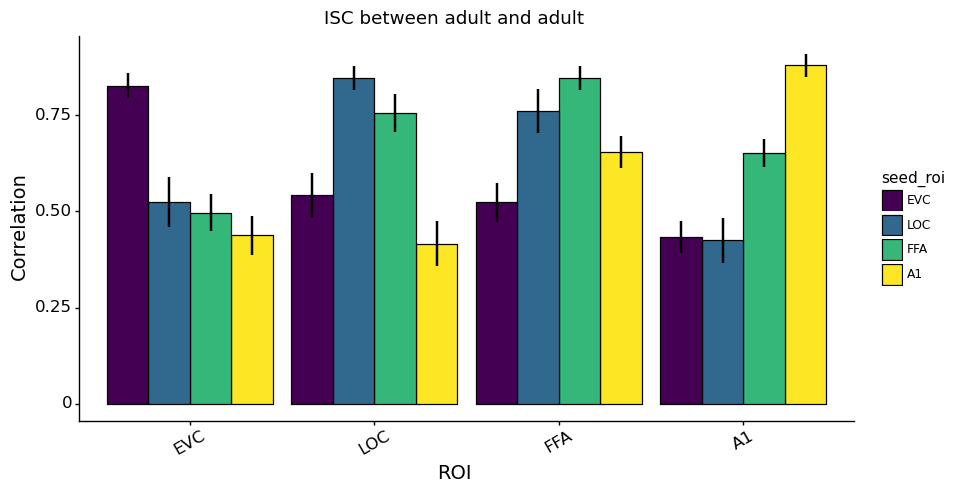

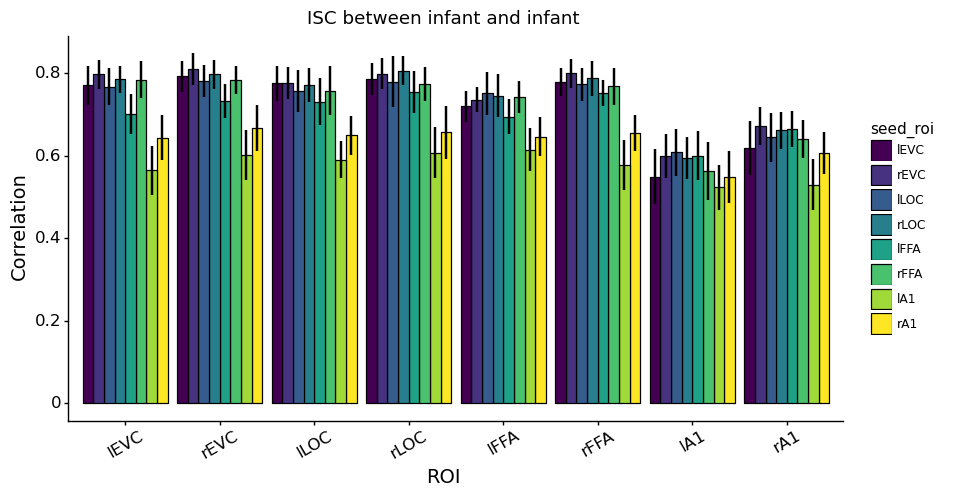

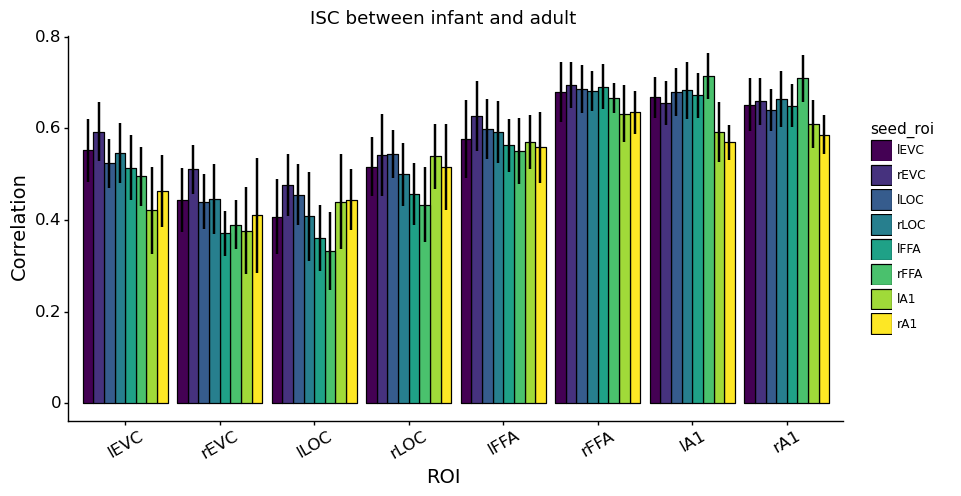

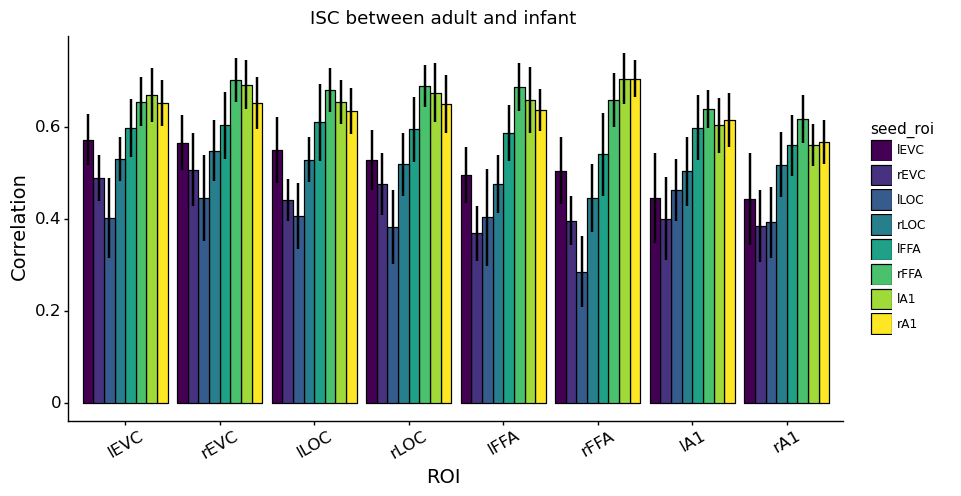

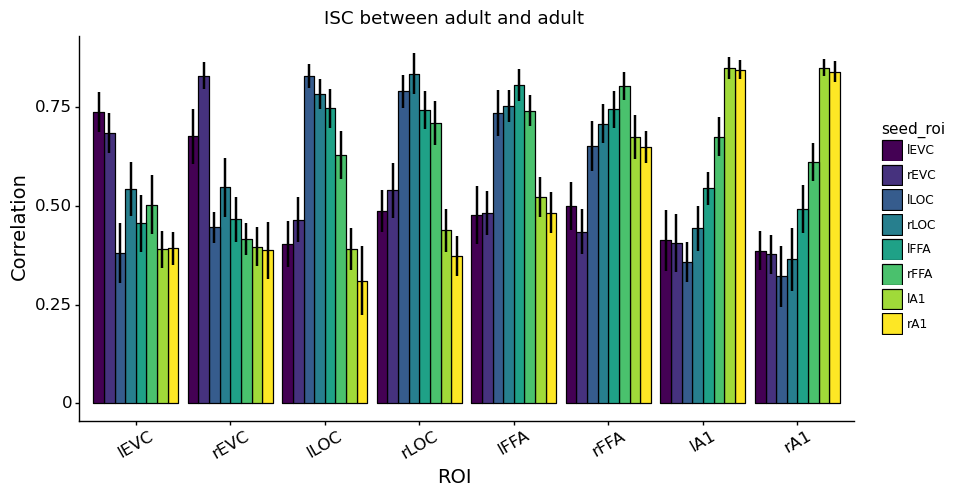

In [14]:
'''
Human summary file
'''
file_suf = '_face'
cv = 'shuffle'
predictor = 'human'
analysis_type = 'mean_sub_crossval'
#dv_ages = ['infant','adult']
roi_sets = [bi_rois] + [lat_rois]

summary_df = pd.read_csv(f'{results_dir}/isc/isc_{predictor}_{cv}{file_suf}.csv')

for roi in roi_sets:
    #extract rois from summary file
    roi_data = summary_df[summary_df['target_roi'].isin(roi)]
    roi_data = roi_data[roi_data['seed_roi'].isin(roi)]
    roi_data['target_roi'] = pd.Categorical(roi_data['target_roi'], categories = roi, ordered = True)
    roi_data['seed_roi'] = pd.Categorical(roi_data['seed_roi'], categories = roi, ordered = True)
    for seed_age in ages:
        
        for target_age in ages:
            #plot corr data as bar graph
            corr_data = roi_data[(roi_data['seed_age'] == seed_age) & (roi_data['target_age'] == target_age)]
            create_bar(corr_data, 'target_roi', 'isc_mean','seed_roi', 'isc_se', f'ISC between {seed_age} and {target_age}')


    ##groupby train_type, age, roi
    #summary_mean = summary_file.groupby(['train_type','age','roi']).mean().reset_index()


#### Test how face selective each ROI is

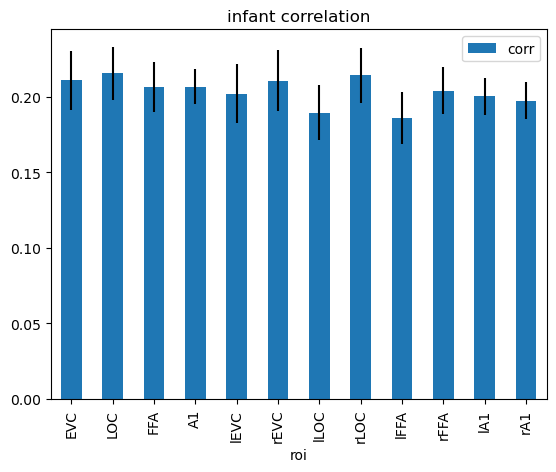

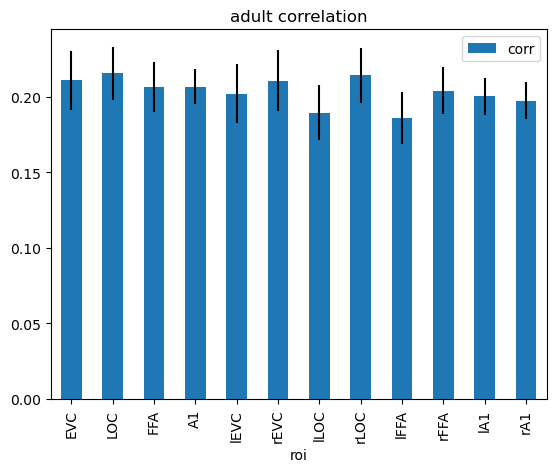

In [15]:
#corr_summary = pd.DataFrame(columns = ['roi','age','corr','se'])
for age in ages:
    curr_sub = sub_list[sub_list['AgeGroup'] == age]
    corr_summary = pd.DataFrame(columns = ['roi','age','corr','se'])
    for roi in rois:
        all_corrs = []
        for sub in sub_list['participant_id']:
            #load correlation data
            corr_data = np.load(f'{data_dir}/sub-{sub}/timeseries/{roi}_roi_corr.npy')

            #extract top-10% of correlations
            corr_data = corr_data[corr_data > np.percentile(corr_data, 90)]

            #calculate median correlation
            corr_median = np.mean(corr_data)

            #append to list
            all_corrs.append(corr_median)

        #calculate mean and se
        corr_mean = np.mean(all_corrs)
        corr_se = np.std(all_corrs)/np.sqrt(len(all_corrs))

        #append to summary file
        corr_summary = corr_summary.append({'roi':roi, 'age':age, 'corr':corr_mean, 'se':corr_se}, ignore_index = True)

    #assign roi order
    corr_summary['roi'] = pd.Categorical(corr_summary['roi'], categories = rois, ordered = True)

    #plot corr data as bar graph
    corr_summary.plot.bar(x = 'roi', y = 'corr', yerr = 'se', title = f'{age} correlation')
    plt.show()
    #plt.savefig(f'{results_dir}/figures/{age}_median_corr.png')


        
            

        

### Model classification accuracy

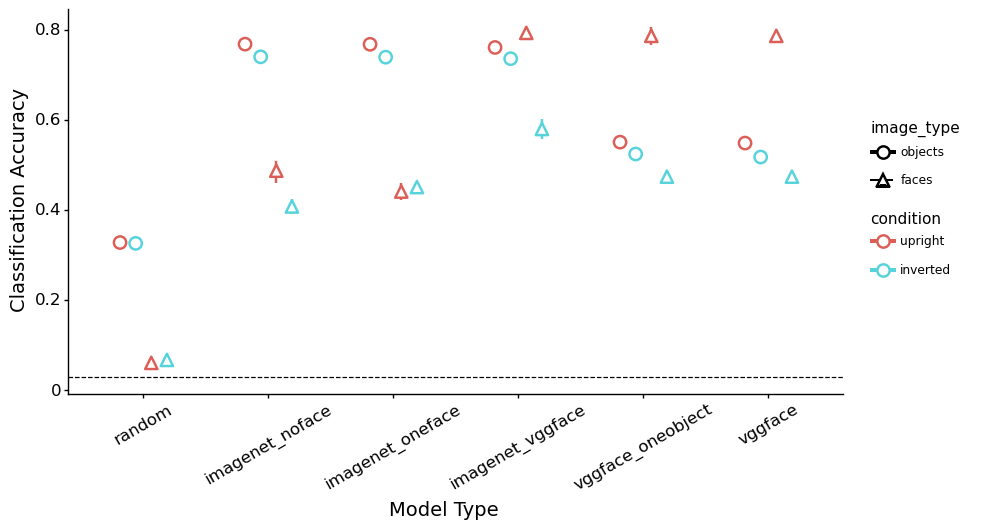

In [4]:
"""
Plot classification mean data
"""
#exp = 'classify'

cond = ['upright','inverted']
test_type = ['objects', 'faces']

suf = ''

summary_df = pd.DataFrame(columns = ['arch','train_type','image_type', 'condition', 'acc', 'se'])
for trt in model_types:
    for tt in test_type:
        for cc in cond:
            
            curr_df = pd.read_csv(f'{results_dir}/classify/{model_arch}_{trt}_avgpool_{tt}_{cc}{suf}.csv')
            curr_data = pd.Series([model_arch,trt,tt,cc, curr_df['acc'].mean(), curr_df['acc'].sem()],
                                    index = summary_df.columns)
            summary_df = summary_df.append(curr_data, ignore_index=True)

    #summary_df = pd.concat([summary_df, curr_data])
summary_df['acc'] = summary_df['acc'].astype(float)
summary_df['se'] = summary_df['se'].astype(float)

summary_df['condition'] = pd.Categorical(summary_df['condition'], categories = cond, ordered = False)
summary_df['image_type'] = pd.Categorical(summary_df['image_type'], categories = test_type, ordered = False)
summary_df['train_type'] = pd.Categorical(summary_df['train_type'], categories = model_types, ordered = False)


#plot = ggplot(summary_df, aes(x = 'model', y = 'acc', fill = 'image_type')) + geom_col(stat='identity', position='dodge') + \
#     lims(y=(0, .5))
#print([mm[1], ll])
plot = ggplot(summary_df, aes(x = 'train_type', y = 'acc', color = 'condition')) + \
    geom_linerange(aes(x='train_type',  ymax = 'acc + se', ymin = 'acc - se', linetype = 'image_type'), size = 1,position=position_dodge2(width=.5)) + \
    geom_point(aes(shape = 'image_type'), size = 4, fill = 'White', stroke = 1,position=position_dodge2(width=.5)) + \
    geom_hline(yintercept=.03, linetype = 'dashed') + theme_classic() + xlab('Model Type') + ylab('Classification Accuracy') + \
            theme(text = element_text(color ='black'), axis_text_x= element_text(angle = 30, size = 12),axis_text_y= element_text(size = 12),axis_title=element_text(size = 14),
                                                                            axis_line=element_line(), 
                                                                            panel_border=element_blank(),
                                                                            figure_size = (10, 5))

print(plot)
#del plot
